# Выбор региона для разработки скважин «ГлавРосГосНефти»

Компании «ГлавРосГосНефть» нужно решить, где бурить новую скважину.

Предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. 

Построим модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируем возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

# 1. Загрузка и подготовка данных

In [1]:
#импортируем библиотеки
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

Сохраним данные по трем регионам в переменные `data0`, `data1`, `data2`. Посмотрим на первые строки.

In [2]:
data0 = pd.read_csv('geo_data_0.csv')
data0.head()

,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647


In [3]:
data1 = pd.read_csv('geo_data_1.csv')
data1.head()

,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305


In [4]:
data2 = pd.read_csv('geo_data_2.csv')
data2.head()

,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746


- id — уникальный идентификатор скважины;
- f0, f1, f2 — три признака точек (неважно, что они означают, но сами признаки значимы);
- product — объём запасов в скважине (тыс. баррелей).

Проверим, нет ли в датасетах пропусков:

In [5]:
for i in [data0, data1, data2]:
    print(i.isna().sum().sum())

0
0
0


Оценим количество данных и уточним типы данных в столбцах. 

In [6]:
for i in [data0, data1, data2]:
    i.info()
    print()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Nul

В каждом датасете по 100000 строк, 4 столбца с числовыми значениями и столбец `id` со значениями типа object.

Проверка на дубли показывает, что в датасетах есть наблюдения с одинаковым 'id' и разными показателями. Их немного; удалим их.

In [7]:
data0[data0.id.isin(data0[data0.duplicated('id') == True].id.to_list())].sort_values('id')

,id,f0,f1,f2,product
66136,74z30,1.084962,-0.312358,6.990771,127.643327
64022,74z30,0.741456,0.459229,5.153109,140.771492
51970,A5aEY,-0.180335,0.935548,-2.094773,33.020205
3389,A5aEY,-0.039949,0.156872,0.209861,89.249364
69163,AGS9W,-0.933795,0.116194,-3.655896,19.230453
42529,AGS9W,1.454747,-0.479651,0.683380,126.370504
931,HZww2,0.755284,0.368511,1.863211,30.681774
7530,HZww2,1.061194,-0.373969,10.430210,158.828695
63593,QcMuo,0.635635,-0.473422,0.862670,64.578675
1949,QcMuo,0.506563,-0.323775,-2.215583,75.496502


In [8]:
data0 = data0.drop(data0[data0.id.isin(data0[data0.duplicated('id') == True].id.to_list())].index)

In [9]:
data1 = data1.drop(data1[data1.id.isin(data1[data1.duplicated('id') == True].id.to_list())].index)

In [10]:
data2 = data2.drop(data2[data2.id.isin(data2[data2.duplicated('id') == True].id.to_list())].index)

Посмотрим на распределение запасов нефти в скважинах в каждом регионе:

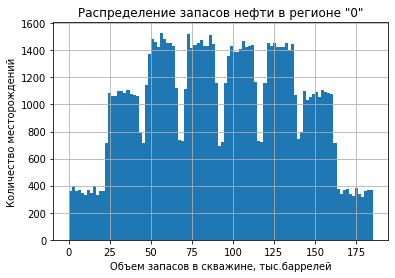

In [11]:
data0['product'].hist(bins = 100)
plt.title('Распределение запасов нефти в регионе "0"')
plt.xlabel('Объем запасов в скважине, тыс.баррелей')
plt.ylabel('Количество месторождений');

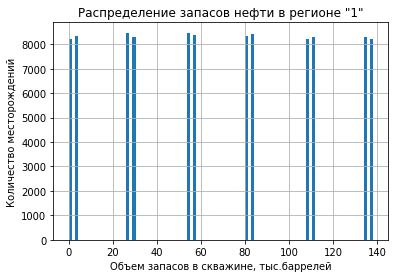

In [12]:
data1['product'].hist(bins = 100)
plt.title('Распределение запасов нефти в регионе "1"')
plt.xlabel('Объем запасов в скважине, тыс.баррелей')
plt.ylabel('Количество месторождений');

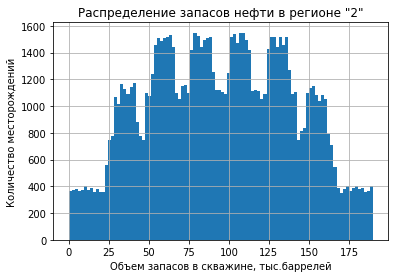

In [13]:
data2['product'].hist(bins = 100)
plt.title('Распределение запасов нефти в регионе "2"')
plt.xlabel('Объем запасов в скважине, тыс.баррелей')
plt.ylabel('Количество месторождений');

Если в регионах "0" и "2" распределение запасов нефти в скважинах отдаленно напоминает нормальное, то в регионе "1" распределение выглядит не очень реалистично. 

Судя по гистограммам, регионы "0" и "2" выглядят более перспективными для нашей задачи: в них значительно выше доля скважин с запасами выше 100 тыс. баррелей.

In [14]:
print('Доля скважин с запасами более 100 тыс.баррелей в регионе "0": {}%'.format(round(data0[data0['product'] > 100]['product'].count() / len(data0)*100)))
print('Доля скважин с запасами более 100 тыс.баррелей в регионе "1": {}%'.format(round(data1[data1['product'] > 100]['product'].count() / len(data1)*100)))
print('Доля скважин с запасами более 100 тыс.баррелей в регионе "2": {}%'.format(round(data2[data2['product'] > 100]['product'].count() / len(data2)*100)))

Доля скважин с запасами более 100 тыс.баррелей в регионе "0": 45.0%
Доля скважин с запасами более 100 тыс.баррелей в регионе "1": 33.0%
Доля скважин с запасами более 100 тыс.баррелей в регионе "2": 47.0%


# 2. Обучение и проверка модели

Напишем функцию, которая будет принимать на вход датасет и:

- выделять признаки и целевой признак, 
- делить данные на обучающую и валидационную выборки (в соотношении 75:25), 
- обучать модель линейной регрессии, 
- делать предсказания целевого признака на валидационной выборке,
- оценивать качество модели (RMSE). 


Результатом работы функции будут сохраненные в отдельные переменные правильные ответы, предсказания, обученная модель и RMSE на валидации.

In [15]:
def modelling(data):
    y = data['product']
    X = data.drop(['product', 'id'], axis = 1)
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.25, random_state = 15)
    model = LinearRegression()
    model.fit(X_train, y_train)
    pred = pd.Series(model.predict(X_val), index = X_val.index)
    rmse = mean_squared_error(y_val, pred) ** 0.5
    return(y_val, pred, model, rmse)

Применим функцию к датасетам с данными по 3 регионам и сравним результаты:

In [16]:
target0, pred0, model0, rmse0 = modelling(data0)
print('Средний запас сырья:', target0.mean())
print('Средний запас сырья (предсказание):', pred0.mean())
print('RMSE:', rmse0)

Средний запас сырья: 92.87677866614192
Средний запас сырья (предсказание): 92.5531514758925
RMSE: 37.61703827526167


In [17]:
target1, pred1, model1, rmse1 = modelling(data1)
print('Средний запас сырья:', target1.mean())
print('Средний запас сырья (предсказание):', pred1.mean())
print('RMSE:', rmse1)

Средний запас сырья: 68.70195536347542
Средний запас сырья (предсказание): 68.69985126903578
RMSE: 0.8907322492888953


In [18]:
target2, pred2, model2, rmse2 = modelling(data2)
print('Средний запас сырья:', target2.mean())
print('Средний запас сырья (предсказание):', pred2.mean())
print('RMSE:', rmse2)

Средний запас сырья: 95.26221341586938
Средний запас сырья (предсказание): 94.95003134594396
RMSE: 39.868073655066745


Судя по RMSE, модель, обученная на данных по региону "1", предсказывает значительно лучше двух остальных.

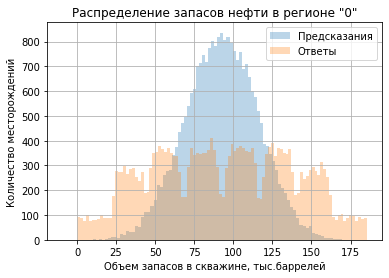

In [19]:
pred0.hist(bins = 100, alpha = 0.3, label = 'Предсказания')
target0.hist(bins = 100, alpha = 0.3, label = 'Ответы')
plt.title('Распределение запасов нефти в регионе "0"')
plt.xlabel('Объем запасов в скважине, тыс.баррелей')
plt.ylabel('Количество месторождений')
plt.legend();

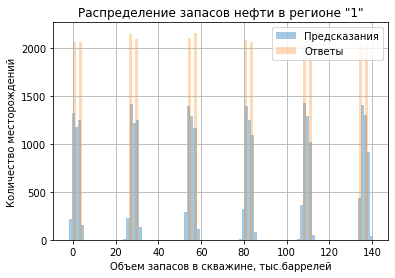

In [20]:
pred1.hist(bins = 100, alpha = 0.4, label = 'Предсказания')
target1.hist(bins = 100, alpha = 0.3, label = 'Ответы')
plt.title('Распределение запасов нефти в регионе "1"')
plt.xlabel('Объем запасов в скважине, тыс.баррелей')
plt.ylabel('Количество месторождений')
plt.legend();

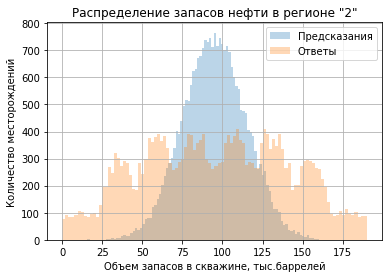

In [21]:
pred2.hist(bins = 100, alpha = 0.3, label = 'Предсказания')
target2.hist(bins = 100, alpha = 0.3, label = 'Ответы')
plt.title('Распределение запасов нефти в регионе "2"')
plt.xlabel('Объем запасов в скважине, тыс.баррелей')
plt.ylabel('Количество месторождений')
plt.legend();

Выясним, какой регион перспективнее с точки зрения потенциальной прибыли.

# 3. Подготовка к расчёту прибыли

Рассчитаем достаточный объём сырья для безубыточной разработки новой скважины:

In [22]:
#Бюджет на разработку скважин в регионе — 10 млрд рублей.
budget = 10000000000
#Один баррель сырья приносит 450 рублей дохода. 
#Доход с каждой единицы продукта составляет 450 тыс. рублей (объём указан в тысячах баррелей).
product_price = 450000
#При разведке региона исследуют 500 точек и выбирают 200 лучших для разработки.
id_count = 200
#Средний объём запасов в скважине (тыс. баррелей) для безубыточной разработки:
min_product = budget / product_price / id_count
print('Средний объём запасов в скважине для безубыточной разработки:', round(min_product, 1), 'тыс.баррелей.')

Средний объём запасов в скважине для безубыточной разработки: 111.1 тыс.баррелей.


In [23]:
#Сравним с этим значением средние показатели по регионам:
print('Средний объем запасов в скважине в регионе "0", тыс.баррелей:', round(data0['product'].mean(), 1))
print('Средний объем запасов в скважине в регионе "1", тыс.баррелей:', round(data1['product'].mean(), 1))
print('Средний объем запасов в скважине в регионе "2", тыс.баррелей:', round(data2['product'].mean(), 1))

Средний объем запасов в скважине в регионе "0", тыс.баррелей: 92.5
Средний объем запасов в скважине в регионе "1", тыс.баррелей: 68.8
Средний объем запасов в скважине в регионе "2", тыс.баррелей: 95.0


В среднем, объем запасов сырья в скважине сильно меньше, чем нужно для безубыточной разработки. Особенно в регионе "1". 

Поэтому качество модели - ее способность правильно предсказывать объем сырья в новых точках - выходит на первый план.

Напишем функцию, которая будет принимать на вход предсказания модели и правильные ответы, выбирать конкретное количество скважин (num) с максимальными значениями предсказаний и считать общую прибыль, которую можно получить с соответствующего объема сырья:

In [24]:
def total_profit(target, pred, num):
    preds = pred.sort_values(ascending = False)
    profit = target[preds.index][:num].sum() * product_price - budget
    return profit

# 4. Расчёт прибыли и рисков 

Применим технику Bootstrap с 1000 выборок, чтобы найти распределение прибыли. Найдём среднюю прибыль, 95%-й доверительный интервал и риск убытков для каждого региона.

In [25]:
def bootstrap(predictions, target, samples, num, fin_num, q1, q2, reg):
    state = np.random.RandomState(12345)
    results = []
    for i in range(samples):
        pred = predictions.sample(num, replace = True, random_state = state)
        targ = target[pred.index]
        results.append(total_profit(targ, pred, fin_num))
    results = pd.Series(results)
    print('Средняя прибыль:', int(results.mean()))
    print('95% доверительный интервал:', int(results.quantile(q1)), '—', int(results.quantile(q2)))
    print('Риск убытка: {}%'.format(round((results < 0).mean() * 100, 1)))
    results.hist(bins = 100)
    plt.xticks([0, 200000000, 400000000, 600000000, 800000000, 1000000000], [0, 200, 400, 600, 800, 1000])
    plt.title('Распределение прибыли в регионе "{}"'.format(reg))
    plt.xlabel('Прибыль, млн руб.');

Средняя прибыль: 487366274
95% доверительный интервал: -52849180 — 994927447
Риск убытка: 3.5%


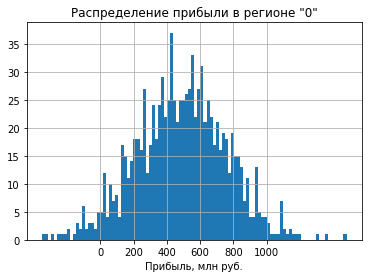

In [26]:
bootstrap(pred0, target0, 1000, 500, 200, 0.025, 0.975, 0)

Средняя прибыль: 481429106
95% доверительный интервал: 35330410 — 905097112
Риск убытка: 1.7%


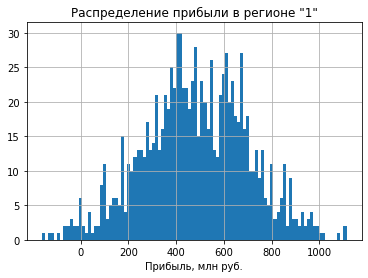

In [27]:
bootstrap(pred1, target1, 1000, 500, 200, 0.025, 0.975, 1)

Средняя прибыль: 472420145
95% доверительный интервал: -98487433 — 1003473010
Риск убытка: 5.5%


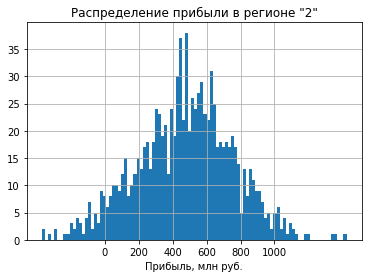

In [28]:
bootstrap(pred2, target2, 1000, 500, 200, 0.025, 0.975, 2)

Только в регионе "1" риск убытков ниже 2.5%. Убыточные варианты не входят в 95% доверительный интервал. При этом среднее значение лишь немного уступает средней прибыли в регионе "0". 

Таким образом, условиям нашей задачи удовлетворяет только регион "1". Это оптимальный выбор.

# Выводы

- Загрузили данные по 3 регионам, избавились от дубликатов и изучили распределения запасов нефти в скважинах в каждом регионе. Судя по распределениям, регионы "0" и "2" выглядят более перспективными для нашей задачи: в них значительно выше доля скважин с запасами выше 100 тыс. баррелей (45-47% против 33% в регионе "1").


- Обучили модели линейной регрессии для каждого региона, сделали предсказания на валидационной выборке и оценили качество моделей при помощи метрики RMSE. Модель, обученная на данных по региону "1", предсказывает значительно лучше двух остальных.


- Рассчитали достаточный объём сырья для безубыточной разработки новой скважины: 111.1 тыс.баррелей. Сравнили этот показатель со средними значениями по регионам. В среднем, объем запасов сырья в скважине сильно меньше, чем нужно для безубыточной разработки. Особенно в регионе "1". 


- Средний объем запасов в скважине в регионе "0": 92.5 тыс.баррелей, в регионе "1": 68.8 тыс.баррелей, в регионе "2": 95.0 тыс.баррелей.


- Таким образом, выбрать точки для разработки "наугад" и получить прибыль не получится: качество модели - ее способность правильно предсказывать объем сырья в новых точках - выходит на первый план.


- Применили технику Bootstrap с 1000 выборок (в каждой из 500 случайно выбранных точек выбрали 200 лучших скважин по предсказаниям и посчитали суммарную прибыль по реальным показателям). Получили распределение прибыли. Найшли среднюю прибыль, 95%-й доверительный интервал и риск убытков.


- Только в регионе "1" риск убытков оказался ниже 2.5%. Убыточные варианты не входят в 95% доверительный интервал. При этом среднее значение лишь немного уступает средней прибыли в регионе "0". Условиям нашей задачи удовлетворяет только регион "1"; выбираем его.


- Таким образом, ситуация неоднозначна. С одной стороны, в регионе "1" самая низкая доля скважин с объемами сырья свыше 100 тыс. баррелей. С другой стороны, в регионе "1" модель лучше всего справляется с предсказаниями. В результате точки, выбранные для разработки в регионе "1", с наибольшей вероятностью принесут прибыль.


- Если возможно значительно повысить качество предсказаний моделей в регионах "0" и "2", это может изменить ситуацию. Если это невозможно, то оптимальным выбором станет разработка в регионе "1", где риск убытков минимален, а возможная прибыль достаточно высока.